# Nếu mỗi tháng đầu tư 5 triệu Việt Nam Đồng từ 01-01-2015 đến hiện tại, loại hình thức đầu tư nào sẽ giúp tổng giá trị tài sản tăng cao nhất vào cuối khoảng thời gian?

## So sánh 3 loại hình thức đầu tư bao gồm: **vàng**, **chứng chỉ quỹ**, **gửi tiết kiệm**

Tải các thư viện cần thiết

In [2]:
%pip install pandas numpy matplotlib vnstock yfinance sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

`import` các thứ viện cần thiết

In [47]:
import pandas as pd
import numpy as np
from vnstock import Fund
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
import yfinance as yf
import datetime
from imblearn.over_sampling import SMOTE
import math
from datetime import date
import matplotlib.pyplot as plt

Tạo `DataFrame` gốc, nơi sẽ lưu trữ tất cả dữ liệu

In [4]:
monthly_invest = 5_000_000
startDate = '2005-01-01'
endDate = pd.to_datetime(date.today())
data = pd.DataFrame(pd.date_range(
    start=startDate,
    end = endDate,
    freq='ME'
),columns=['date']).set_index('date')
data['month'] = range(1,len(data)+1)
data.head(5)


,month
date,
2005-01-31,1
2005-02-28,2
2005-03-31,3
2005-04-30,4
2005-05-31,5


Cột `initialCapital` thể hiện số tiền đã đầu tư tính tới thời điểm đó

In [5]:
data['initialCapital'] = data['month'] * monthly_invest
data.head(5)

,month,initialCapital
date,,
2005-01-31,1,5000000
2005-02-28,2,10000000
2005-03-31,3,15000000
2005-04-30,4,20000000
2005-05-31,5,25000000


Tải các file dữ liệu cần thiết cho quá trình phân tích từ `vnstock`, `yfinance`

In [6]:
fund = Fund()
DCDS = fund.details.nav_report('DCDS')
DCDS.to_csv('DCDS.csv',index=False)

# ===============================
# 1. PARAMETERS
# ===============================




# ===============================
# 2. DOWNLOAD GOLD PRICE (USD / OZ)
# ===============================
gold = yf.download(
    "GC=F",
    start=startDate,
    auto_adjust=True,
    progress=False
)
gold.columns = gold.columns.droplevel(1)
gold.to_csv('GOLD.csv',index=True)

# ===============================
# 3. DOWNLOAD USD/VND EXCHANGE RATE
# ===============================
usd = yf.download(
    "VND=X",
    start=startDate,
    auto_adjust=True,
    progress=False
)
usd.columns = usd.columns.droplevel(1)
usd.to_csv('USD.csv',index=True)


silver = yf.download(
    "SI=F",
    start=startDate,
    auto_adjust=True,
    progress=False
)
silver.columns = silver.columns.droplevel(1)
silver.to_csv('SILVER.csv',index=True)

2026-01-01 08:33:31 - vnstock.explorer.fmarket.fund - INFO - Total number of funds currently listed on Fmarket: 61
2026-01-01 08:33:31 - vnstock.explorer.fmarket.fund - INFO - Retrieving data for DCDS


## Chứng chỉ quỹ

Chứng chỉ quỹ là một loại giấy tờ xác nhận quyền sở hữu của nhà đầu tư đối với một phần tài sản của quỹ đầu tư. Nói cách khác, khi bạn mua chứng chỉ quỹ, bạn đang góp vốn vào quỹ đó, và quỹ sẽ dùng số tiền này để đầu tư vào cổ phiếu, trái phiếu, bất động sản hoặc các công cụ tài chính khác tùy theo mục tiêu của quỹ.

### Thu thập dữ liệu
Thu thập dữ liệu giá của chứng chỉ quỹ (đại diện ở đây là **DCDS (Quỹ Đầu Tư Chứng Khoán Năng Động DC)**)

In [7]:
DCDS = pd.read_csv('DCDS.csv',index_col='date')
DCDS.index = pd.to_datetime(DCDS.index)
DCDS.head()

,nav_per_unit,short_name
date,,
2004-05-20,10000.00,DCDS
2004-05-31,10000.00,DCDS
2004-06-30,10099.00,DCDS
2004-07-31,10040.42,DCDS
2004-08-31,10021.00,DCDS


### Làm sạch dữ liệu

Đổi tên cột `nav_per_unit` để dễ hiểu hơn thành `price`, sau đó bỏ cột `short_name` vì không cần thiết. Để đảm bảo thứ tự giá được sắp xếp đúng, sử dụng `.sort_index()` với **index** là thời gian đã được biến đổi thành dạng có thể so sánh được.

In [8]:
DCDS.rename(columns={'nav_per_unit':'price'},inplace=True)
DCDS.drop('short_name',axis=1,inplace=True)
DCDS = DCDS.sort_index()
DCDS.head(5)


,price
date,
2004-05-20,10000.00
2004-05-31,10000.00
2004-06-30,10099.00
2004-07-31,10040.42
2004-08-31,10021.00


Vì dữ liệu gồm nhiều mức giá trong nhiều ngày của một tháng, ta nhóm hàng lại và chỉ lấy giá cuối cùng của tháng đó, sử dụng `.resample('MS).first()`. Sau đó, lọc các giá trị trong khoảng thời gian xét *(31-01-2015 đến 31-01-2025)*, sử dụng `.loc[]`. Ta sẽ thay thế các dữ liệu giá bị thiếu (nếu có) bằng dữ liệu giá gần nhất trước nó không bị thiếu. 

In [9]:
DCDS = (DCDS
        .resample('ME')
        .last().round(2)
)
DCDS = DCDS.loc[(DCDS.index >= startDate) & (DCDS.index<= endDate)]
DCDS = DCDS.join(data['month'],how='right')
DCDS['price'] = DCDS['price'].ffill().bfill()
DCDS.head(5)


,price,month
date,,
2005-01-31,10183.86,1
2005-02-28,10445.01,2
2005-03-31,10548.13,3
2005-04-30,10308.50,4
2005-05-31,10315.02,5


### Xử lí dữ liệu

Tính số lượng đơn vị **chứng chỉ quỹ** mỗi tháng mua được, cột `'QtyThisMonth'` sẽ thể hiện số lượng đơn vị mua được. Quỹ DCDS cho phép mua với số lượng có 2 số sau dấu thập phân, vì vậy số lượng sẽ được tính tới 2 số thập phân, phần còn lại sẽ được lưu lại để cộng vào tháng sau. sau đó tính tổng số lượng **chứng chỉ quỹ** (cột `TotalQty`) sở hữu và giá trị của khoản đầu tư(cột `PortfolioValue`).

In [10]:

DCDS['QtyThisMonth'] = 0.0
DCDS['remain'] = 0.0
for i in range(len(DCDS)):
    if (i == 0):
        budget = monthly_invest
    else:
        budget = monthly_invest + DCDS.loc[DCDS.index[i-1],'remain']
    DCDS.loc[DCDS.index[i],'QtyThisMonth'] = math.floor(budget * 100  / DCDS.loc[DCDS.index[i],'price']) /100
    DCDS.loc[DCDS.index[i],'remain'] = budget - DCDS.loc[DCDS.index[i],'QtyThisMonth']* DCDS.loc[DCDS.index[i],'price']

DCDS['TotalQty'] = DCDS['QtyThisMonth'].cumsum()
DCDS['PortfolioValue'] = DCDS['TotalQty'] * DCDS['price'] + DCDS['remain']
DCDS.head(5)

,price,month,QtyThisMonth,remain,TotalQty,PortfolioValue
date,,,,,,
2005-01-31,10183.86,1,490.97,30.2558,490.97,5.000000e+06
2005-02-28,10445.01,2,478.70,3.9688,969.67,1.012822e+07
2005-03-31,10548.13,3,474.01,84.8675,1443.68,1.522821e+07
2005-04-30,10308.50,4,485.04,50.0275,1928.72,1.988226e+07
2005-05-31,10315.02,5,484.73,50.3829,2413.45,2.489484e+07


## Ngân hàng

Tính giá trị của khoản đầu tư theo từng tháng nếu gửi ngân hàng với lãi suất `5%/năm`

In [11]:
anual_interest = 5/100
yearly_save = monthly_invest * 12
Bank =pd.DataFrame(pd.date_range(start=startDate,end=endDate,freq='ME'),columns=['date']).set_index('date')
Bank[['month','PortfolioValue']] = data[['month','initialCapital']].copy()
Bank['PortfolioValue'] = Bank['PortfolioValue'].astype('float')
for i in range(len(Bank)):
    if (i<12):
        continue
    Bank.loc[Bank.index[i],'PortfolioValue'] = Bank.loc[Bank.index[i-12],'PortfolioValue'] * (1+anual_interest) + yearly_save
Bank['PortfolioValue']=Bank['PortfolioValue'].round(2)
Bank.head(5)



,month,PortfolioValue
date,,
2005-01-31,1,5000000.0
2005-02-28,2,10000000.0
2005-03-31,3,15000000.0
2005-04-30,4,20000000.0
2005-05-31,5,25000000.0


## Vàng

### Thu thập dữ liệu

Thu thập giá vàng theo **USD/Ounce** và **USD/VND** từ `yfinance`

In [12]:
USDVND_MIN_VALID = 10000  # USD/VND has never been below this since 2000
gramPerOz = 31.1035
chiPerGram = 1/37.5 * 10
chiPerOz = gramPerOz * chiPerGram

gold = pd.read_csv('GOLD.csv',header=0,index_col='Date')
gold.index = pd.to_datetime(gold.index)
gold.head(5)


,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,428.700012,431.000000,431.000000,431.000000,4
2005-01-04,428.500000,428.500000,428.500000,428.500000,108
2005-01-05,426.600006,425.700012,425.700012,425.700012,2
2005-01-06,421.000000,421.000000,421.000000,421.000000,1
2005-01-07,418.899994,423.700012,418.700012,423.700012,1


In [13]:
usd = pd.read_csv('USD.csv',header= 0,index_col = 'Date')
usd.index = pd.to_datetime(usd.index)
usd.head()

,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,15771.0,15771.0,15443.0,15443.0,0
2005-01-04,15773.0,15773.0,15329.0,15329.0,0
2005-01-05,15775.0,15775.0,15428.0,15428.0,0
2005-01-06,15785.0,15785.0,15322.0,15322.0,0
2005-01-07,15785.0,15785.0,15298.0,15298.0,0


### Làm sạch dữ liệu

Nhóm dữ liệu theo tháng. Sau đó nếu tháng nào chưa có dữ liệu thì sẽ lấy dữ liệu trước đó gần nhất không bị thiếu

In [14]:
gold = gold.resample('ME').last().join(data['month'],how='right').ffill().bfill()
gold.drop(columns=['High','Low','Open','Volume'],axis=1,inplace=True)
gold = gold.loc[(gold.index >= startDate) & (gold.index <= endDate)]
gold.rename(columns={'Close':'USD/Oz'},inplace=True)
gold.head(5)

,USD/Oz,month
date,,
2005-01-31,421.799988,1
2005-02-28,436.500000,2
2005-03-31,428.700012,3
2005-04-30,435.000000,4
2005-05-31,416.299988,5


In [15]:

usd = usd.resample('ME').last()
usd.loc[usd['Close']<USDVND_MIN_VALID,'Close'] = pd.NA
usd =usd.join(data['month'],how='right')
usd['Close'] = usd['Close'].ffill()
usd.drop(columns=['High','Low','Open','Volume'],axis=1,inplace=True)
usd = usd.loc[(usd.index >= startDate) & (usd.index <= endDate)]
usd.head(5)

,Close,month
date,,
2005-01-31,15781.0,1
2005-02-28,15796.0,2
2005-03-31,15825.0,3
2005-04-30,15825.0,4
2005-05-31,15855.0,5


### Xử lí dữ liệu
Vì vàng không thể mua lẻ mà nhỏ nhất là theo chỉ nên đơn vị sẽ là chỉ.

In [16]:
gold['vnd/chi'] = gold['USD/Oz'] *usd['Close']/ chiPerOz
gold['ThisMonthQty'] = 0
gold['remain'] = 0.0

for i in range(len(gold)):
    if (i == 0):
        budget = monthly_invest
    else:
        budget = monthly_invest + gold.loc[gold.index[i-1],'remain']
    gold.loc[gold.index[i],'ThisMonthQty'] = math.floor(budget / gold.loc[gold.index[i],'vnd/chi']) 
    gold.loc[gold.index[i],'remain'] = budget - gold.loc[gold.index[i],'ThisMonthQty'] * gold.loc[gold.index[i], 'vnd/chi']
gold['TotalQty'] = gold['ThisMonthQty'].cumsum()
gold['PortfolioValue'] = np.floor((gold['remain'] + gold['vnd/chi'] * gold['TotalQty'])*100)//100
gold.head(5)

,USD/Oz,month,vnd/chi,ThisMonthQty,remain,TotalQty,PortfolioValue
date,,,,,,,
2005-01-31,421.799988,1,802533.349224,6,184799.904653,6,5000000.0
2005-02-28,436.500000,2,831291.574903,6,197050.455234,12,10172549.0
2005-03-31,428.700012,3,817935.806241,6,289435.617789,18,15012280.0
2005-04-30,435.000000,4,829955.832945,6,309700.620120,24,20228640.0
2005-05-31,416.299988,5,795782.987420,6,535002.695601,30,24408492.0


## Bạc

### Thu thập dữ liệu

Thu thập dữ liệu giá bạc **USD/Oz** từ `yfinance`

In [17]:
silver = pd.read_csv('SILVER.csv',header = 0, index_col = 'Date')
silver.index = pd.to_datetime(silver.index)
silver.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2005-01-03,6.477,6.740,6.477,6.740,2
2005-01-04,6.427,6.450,6.427,6.450,1
2005-01-05,6.512,6.512,6.512,6.512,51
2005-01-06,6.433,6.433,6.433,6.433,1
2005-01-07,6.429,6.440,6.415,6.440,216


### Làm sạch dữ liệu

Nhóm dữ liệu theo tháng. Sau đó xóa các cột không cần thiêt. Đổi tên cột `close` thành `USD/Oz` để tăng tính đọc hiểu. Cuối cùng kết nối hai bảng với nhau để đảm bảo **bảng dữ liệu của bạc** có cùng số lượng tháng với **bảng dữ liệu chính**

In [18]:
silver = silver.rename(columns = {'Close':'USD/Oz'}).resample('ME').last()

silver.drop(columns=['High','Low','Open','Volume'],axis = 1,inplace = True)
silver = silver.join(data['month'],how = 'right').ffill().bfill()
silver = silver.loc[(silver.index >= startDate) & (silver.index <= endDate)]
silver.head(5)



,USD/Oz,month
date,,
2005-01-31,6.737,1
2005-02-28,7.359,2
2005-03-31,7.191,3
2005-04-30,6.902,4
2005-05-31,7.444,5


### Xử lí dữ liệu

In [19]:
silver['VND/gram'] = np.floor(silver['USD/Oz'] * usd['Close']/gramPerOz*100)/100
silver['ThisMonthQty'] = 0
silver['remain'] = 0.0
indices = silver.index
for i in range(len(silver)):
    if i == 0: 
        budget = monthly_invest
    else:
        budget = monthly_invest + silver.loc[indices[i-1],'remain']


    silver.loc[indices[i],'QtyThisMonth'] = math.floor(budget / silver.loc[indices[i],'VND/gram'])
    silver.loc[indices[i],'remain'] = budget - silver.loc[indices[i],'QtyThisMonth'] * silver.loc[indices[i],'VND/gram']

silver['TotalQty'] = silver['QtyThisMonth'].cumsum()
silver['PortfolioValue'] = silver['remain'] + silver['TotalQty'] * silver['VND/gram']
silver.head(5)

,USD/Oz,month,VND/gram,ThisMonthQty,remain,QtyThisMonth,TotalQty,PortfolioValue
date,,,,,,,,
2005-01-31,6.737,1,3418.15,0,2664.70,1462.0,1462.0,5000000.00
2005-02-28,7.359,2,3737.28,0,2184.06,1338.0,2800.0,10466568.06
2005-03-31,7.191,3,3658.67,0,782.17,1367.0,4167.0,15246460.06
2005-04-30,6.902,4,3511.63,0,221.05,1424.0,5591.0,19633744.38
2005-05-31,7.444,5,3794.57,0,2772.36,1317.0,6908.0,26215661.92


Kiểm tra các khoản đầu tư có tổng số lượng tháng bằng nhau, để khi ghép không xảy ra lỗi

In [20]:
print(Bank.shape,DCDS.shape,gold.shape,silver.shape)

(252, 2) (252, 6) (252, 7) (252, 8)


Ghép các cột từ các bảng giá trị khác vào **bảng giá trị chính**

In [21]:
data['DCDS'] = DCDS['PortfolioValue']
data['Bank'] = Bank['PortfolioValue']
data['Gold'] = gold['PortfolioValue']
data['Silver'] = silver['PortfolioValue']

Vẽ biểu đồ để trực quan hóa các khoản đầu tư giúp dễ so sánh

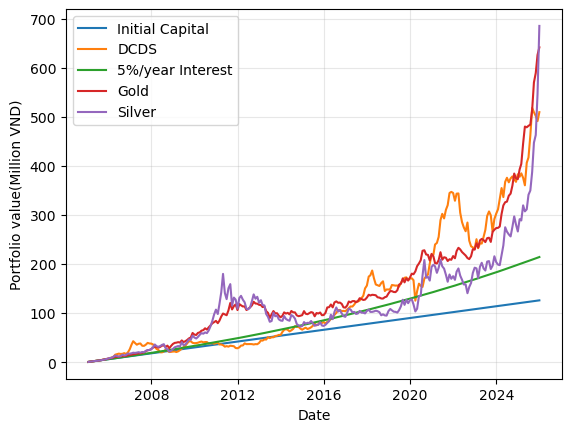

In [22]:
plt.plot(data.index, data['initialCapital']/1_000_0000,label = 'Initial Capital')
plt.plot(data.index,data['DCDS']/1_000_0000, label = 'DCDS')
plt.plot(data.index, data['Bank']/1_000_0000, label = '5%/year Interest')
plt.plot(data.index,data['Gold']/1_000_0000,label='Gold')
plt.plot(data.index,data['Silver']/1_000_0000, label = 'Silver')
plt.xlabel('Date')
plt.ylabel('Portfolio value(Million VND)')
plt.grid(alpha=0.3)

plt.legend()
plt.show()



# Dự đoán sự thay đổi về giá của các loại tài sản.

Thiết lập các hàm để tính các chỉ số cần thiết

In [55]:
golddf = pd.DataFrame()
silverdf = pd.DataFrame()
dcdsdf = pd.DataFrame()
#Returning
def returning(data):
    return ((data - data.shift(3)).shift(1) > 0).astype(int), \
    ((data - data.shift(6)).shift(1) > 0).astype(int),\
    ((data- data.shift(12)).shift(1) > 0).astype(int)
#Rolling statistics
def ma(data):
    return (data.rolling(3).mean().shift(1)),\
        (data.rolling(6).mean().shift(1)),\
            (data.rolling(12).mean().shift(1))
def volatility(data):
    return (data.rolling(3).std().shift(1)),(data.rolling(6).std().shift(1)),(data.rolling(12).std().shift(1))
def highlow(data):
    return (data.rolling(3).max().shift(1)), (data.rolling(6).max().shift(1)), (data.rolling(12).max().shift(1)),(data.rolling(3).min().shift(1)), (data.rolling(6).min().shift(1)), (data.rolling(12).min().shift(1))
#Momentum/Trend
def longTermMomentum(data):
    return (data - data.shift(12)).shift(1)
def trendSlope(ma6,ma12):
    return (ma6 - ma12)


Tạo các chỉ số dùng cho dự đoán **vàng**

In [24]:
golddf['return_3m'], golddf['return_6m'], golddf['return_12m'] = returning(gold['vnd/chi'])
golddf['ma_3m'], golddf['ma_6m'], golddf['ma_12m'] = ma(gold['vnd/chi'])
golddf['vol_3m'], golddf['vol_6m'], golddf['vol_12m'] = volatility(gold['vnd/chi'])
golddf['high_3m'], golddf['high_6m'], golddf['high_12m'], golddf['low_3m'], golddf['low_6m'], golddf['low_12m'] = highlow(gold['vnd/chi'])
golddf['momentum_12m'] = longTermMomentum(gold['vnd/chi'])
golddf['trendSlope'] = trendSlope(golddf['ma_6m'],golddf['ma_12m'])
golddf = golddf.dropna()

Tạo các chỉ số dùng cho dự đoán **bạc**

In [25]:
silverdf['return_3m'], silverdf['return_6m'], silverdf['return_12m'] = returning(silver['VND/gram'])
silverdf['ma_3m'], silverdf['ma_6m'], silverdf['ma_12m'] = ma(silver['VND/gram'])
silverdf['vol_3m'], silverdf['vol_6m'], silverdf['vol_12m'] = volatility(silver['VND/gram'])
silverdf['high_3m'], silverdf['high_6m'], silverdf['high_12m'], silverdf['low_3m'], silverdf['low_6m'], silverdf['low_12m'] = highlow(silver['VND/gram'])
silverdf['momentum_12m'] = longTermMomentum(silver['VND/gram'])
silverdf['trendSlope'] = trendSlope(silverdf['ma_6m'],silverdf['ma_12m'])
silverdf = silverdf.dropna()

Tạo các chỉ số dùng cho dự đoán **Quỹ Đầu Tư Chứng Khoán Năng Động DC**

In [26]:
dcdsdf['return_3m'], dcdsdf['return_6m'], dcdsdf['return_12m'] = returning(DCDS['price'])
dcdsdf['ma_3m'], dcdsdf['ma_6m'], dcdsdf['ma_12m'] = ma(DCDS['price'])
dcdsdf['vol_3m'], dcdsdf['vol_6m'], dcdsdf['vol_12m'] = volatility(DCDS['price'])
dcdsdf['high_3m'], dcdsdf['high_6m'], dcdsdf['high_12m'], dcdsdf['low_3m'], dcdsdf['low_6m'], dcdsdf['low_12m'] = highlow(DCDS['price'])
dcdsdf['momentum_12m'] = longTermMomentum(DCDS['price'])
dcdsdf['trendSlope'] = trendSlope(dcdsdf['ma_6m'],dcdsdf['ma_12m'])
dcdsdf = dcdsdf.dropna()

## Dự đoán sự thay đổi giá **vàng**

In [27]:
features1 = []
correlations = golddf.corr()['return_12m']
for feature in correlations.index:
    if feature!='return_12m' and  abs(correlations[feature]) >= 0.5:
        features1.append(feature)
features1


['return_6m', 'momentum_12m']

In [51]:
split = math.floor(0.5 * len(golddf))
x_train1 = golddf[features1].iloc[0:split]
x_test1 = golddf[features1].iloc[split:]

y_train1 = golddf['return_12m'].iloc[:split]
y_test1 = golddf['return_12m'].iloc[split:]


smote = SMOTE(random_state=42,sampling_strategy=0.5)
x_train_res, y_train_res = smote.fit_resample(x_train1, y_train1)



modelgold = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    class_weight='balanced',
    random_state=42)
modelgold.fit(x_train_res,y_train_res)
predicted1 = modelgold.predict(x_test1)
proba1 = modelgold.predict_proba(x_test1)
print("Accuracy:", accuracy_score(y_test1, predicted1))
print(classification_report(y_test1, predicted1))
print(f"Sau 12 tháng kể từ {golddf.index[-1].strftime("%Y-%m")} vàng sẽ {pd.DataFrame(proba1,columns=['không tăng','tăng']).iloc[-1].idxmax()}")


Accuracy: 0.9833333333333333
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.98      1.00      0.99        99

    accuracy                           0.98       120
   macro avg       0.99      0.95      0.97       120
weighted avg       0.98      0.98      0.98       120

Sau 12 tháng kể từ 2025-12 vàng sẽ tăng


## Dự đoán sự thay đổi giá **bạc**

In [29]:
features2 = []
correlations = silverdf.corr()['return_12m']
for feature in correlations.index:
    if feature!='return_12m' and  abs(correlations[feature]) >= 0.5:
        features2.append(feature)
features2


['return_6m', 'momentum_12m', 'trendSlope']

In [53]:

x_train2 = silverdf[features2].iloc[0:split]
x_test2 = silverdf[features2].iloc[split:]

y_train2 = silverdf['return_12m'].iloc[:split]
y_test2 = silverdf['return_12m'].iloc[split:]


#smote = SMOTE(random_state=42,sampling_strategy=0.3)
#x_train_res, y_train_res = smote.fit_resample(x_train, y_train)



modelsilver = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    class_weight='balanced',
    random_state=42)
modelsilver.fit(x_train2,y_train2)
predicted = modelsilver.predict(x_test2)
proba2 = modelsilver.predict_proba(x_test2)
print("Accuracy:", accuracy_score(y_test2, predicted))
print(classification_report(y_test2, predicted))
print(f"Sau 12 tháng kể từ {silverdf.index[-1].strftime("%Y-%m")} bạc sẽ {pd.DataFrame(proba2,columns=['không tăng','tăng']).iloc[-1].idxmax()}")

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        74

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Sau 12 tháng kể từ 2025-12 bạc sẽ tăng


## Dự đoán sự thay đổi của **Quỹ Đầu Tư Chứng Khoán Năng Động DC**

In [31]:
features3 = []
correlations = dcdsdf.corr()['return_12m']
for feature in correlations.index:
    if feature!='return_12m' and  abs(correlations[feature]) >= 0.5:
        features3.append(feature)
features3


['return_6m', 'momentum_12m', 'trendSlope']

In [54]:

x_train3 = dcdsdf[features3].iloc[0:split]
x_test3 = dcdsdf[features3].iloc[split:]

y_train3 = dcdsdf['return_12m'].iloc[:split]
y_test3 = dcdsdf['return_12m'].iloc[split:]


#smote = SMOTE(random_state=42,sampling_strategy=0.3)
#x_train_res, y_train_res = smote.fit_resample(x_train, y_train)



modeldcds = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    class_weight='balanced',
    random_state=42)
modeldcds.fit(x_train3,y_train3)
predicted = modeldcds.predict(x_test3)
proba3 = modeldcds.predict_proba(x_test3)
print("Accuracy:", accuracy_score(y_test3, predicted))
print(classification_report(y_test3, predicted))
print(f"Sau 12 tháng kể từ {dcdsdf.index[-1].strftime("%Y-%m")} Quỹ Đầu Tư Chứng Khoán Năng Động DC sẽ {pd.DataFrame(proba3,columns=['không tăng','tăng']).iloc[-1].idxmax()}")

Accuracy: 0.9916666666666667
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.99      0.99        89

    accuracy                           0.99       120
   macro avg       0.98      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Sau 12 tháng kể từ 2025-12 Quỹ Đầu Tư Chứng Khoán Năng Động DC sẽ tăng
